In [1]:
#%matplotlib widget
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from pathlib import Path

#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
#rc('text', usetex=True)

In [2]:
def Matrix_Creator(Raw, Pixels):
    image_pair = []
    for k in range(0, len(Raw), Pixels*Pixels):
        blank = np.zeros((Pixels, Pixels))
        for i in range(Pixels):
            for j in range(Pixels):
                blank[i, j] = Raw[j + Pixels*i + k]
        image_pair.append(blank)
    return image_pair

def DataImport(path, extension, Pixels, NRaw):
    data = []
    eff_num = 0

    # Fist, we compute the normal images taken from the simulation.
    try:
        for i in range(1, NRaw + 1):
            step = "{}_{}.raw".format(extension, i)
            Raw = np.fromfile(path / Path(step), dtype='float32')
            matrix = Matrix_Creator(Raw, Pixels)
            data.append(matrix)
        print("1. The dithering image {} has been succesfully ran with {} beamruns.".format(path, i))
    except Exception as e:
        print("1. The dithering image {} has only {} beamruns.".format(path, i - 1))
        print("{}".format(e))
        eff_num = i - 1
        None
        
    # This value represents the beamruns made for each set.
    if eff_num == 0:
        eff_num = NRaw
    else:
        None
    
    return data, eff_num

def ImageGenerator(data, N_images, N_Dopple):
    images = []
    for i in range(0, N_images):
        mean = 0
        for j in range(0, N_Dopple):
            mean += data[i][j]
        mean = mean/N_Dopple
        images.append(mean)  
    return images

def IntensityMean(image, Pixels, cut):
    intensity = np.zeros(Pixels)
    for i in range(0, Pixels):
        intensity += image[i, 0:Pixels]
    intensity = intensity[cut:-cut]
    mean = intensity/np.max(intensity)
    return mean


def Average(name,X1,X2,Step):
    P = np.copy(name)
    for i in range(len(P)):
        P[i,X1:X2] = (1/2)*(P[i,X1-Step:X2-Step]+P[i,X1+Step:X2+Step])
    return P

In [3]:
def LoadingImages(raw, directory, variation, extension, pixel, n_dithstep, n_typeCOL, n_beamrun):
    images = []
    is_FF = False
    for i in range(1, n_dithstep + 1):
        print("----- Set #{} is being analyzed ------".format(i))
        number = str(i)
        path = Path(raw) / Path(directory) / Path(variation) / Path(number)
        data, eff_num = DataImport(path, extension, pixel, n_beamrun) 
        generated_images = ImageGenerator(data, eff_num, n_typeCOL + 1)
        image = np.zeros_like(generated_images[0])
        
        for j in generated_images:
            image += j
        images.append(image)
        print("----- Set #{} has been succesfully analyzed ------ \n".format(i))
    
    try:
        print("----- The Flat Field is being analyzed ------")
        ff_tag = "FF"
        path = Path(raw) / Path(directory) / Path(variation) / Path(ff_tag)
        ffdata, ffeff_num = DataImport(path, extension, pixel, n_beamrun)
        ffimages = ImageGenerator(ffdata, ffeff_num, n_typeCOL + 1)
        ffimage = np.zeros_like(ffimages[0])
        for k in ffimages:
            ffimage += k
        is_FF = True
        print("----- The Flat Field has been succesfully analyzed ------ \n")
        
    except Exception as e:
        print("There is no flat field available for this set.")
    
    # Normalization:
    if is_FF == True:
        try:
            for l in range(0, len(images)):
                images[l] = images[l]/ffimage
            print("The set of images was successfully normalized.")
        except Exception as e:
            print("The normalization was not possible due to an error: {}.".format(e))

    return images

In [200]:
pixel = 256
n_typeCOL = 1
n_dithstep = 4
n_beamrun = 1
raw = "raw_"
txt = "txt"

In [201]:
directory = "Tubes_All"
variation = "5um"
extension = "Piece"
study = "Tube"

In [202]:
images = LoadingImages(raw, directory, variation, extension, pixel, n_dithstep, n_typeCOL, n_beamrun)

----- Set #1 is being analyzed ------
1. The dithering image raw_\Tubes_All\5um\1 has been succesfully ran with 1 beamruns.
----- Set #1 has been succesfully analyzed ------ 

----- Set #2 is being analyzed ------
1. The dithering image raw_\Tubes_All\5um\2 has been succesfully ran with 1 beamruns.
----- Set #2 has been succesfully analyzed ------ 

----- Set #3 is being analyzed ------
1. The dithering image raw_\Tubes_All\5um\3 has been succesfully ran with 1 beamruns.
----- Set #3 has been succesfully analyzed ------ 

----- Set #4 is being analyzed ------
1. The dithering image raw_\Tubes_All\5um\4 has been succesfully ran with 1 beamruns.
----- Set #4 has been succesfully analyzed ------ 

----- The Flat Field is being analyzed ------
1. The dithering image raw_\Tubes_All\5um\FF has been succesfully ran with 1 beamruns.
----- The Flat Field has been succesfully analyzed ------ 

The set of images was successfully normalized.


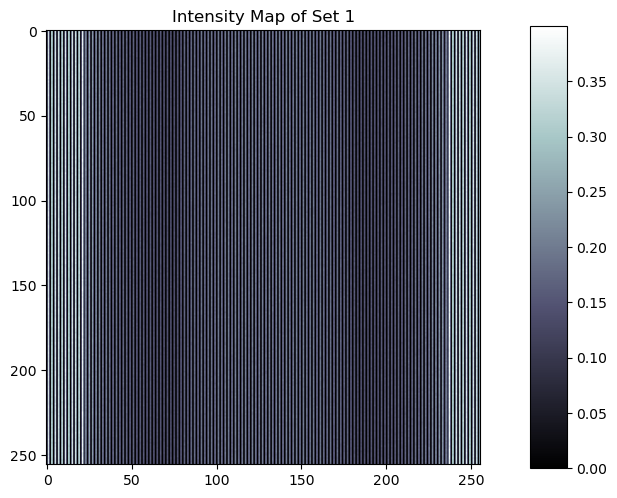

In [203]:
k = 0
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Intensity Map of Set {}".format(k + 1))
map_ = ax.imshow(images[k], cmap = "bone")
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)

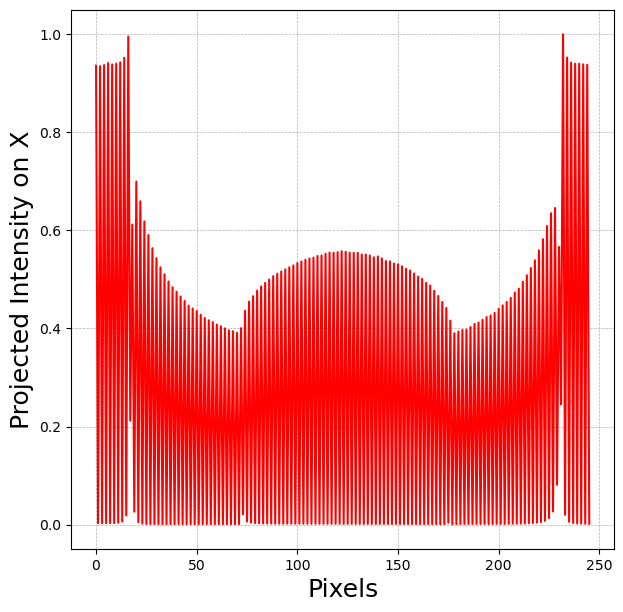

In [204]:
fig, ax = plt.subplots(figsize=(7, 7))
intensities = IntensityMean(images[k], pixel, 5)
ax.plot(intensities, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 18)
ax.set_ylabel("Projected Intensity on X", fontsize = 18)
ax.grid(linestyle = '--', linewidth = 0.5)

In [205]:
look_for = Path("image_set") / Path(directory)
text_path = look_for / Path(variation)
text_path

WindowsPath('image_set/Tubes_All/5um')

In [206]:
look_for = Path("image_set") / Path(directory)
text_path = look_for / Path(variation)
try: 
    os.mkdir(look_for)
    print("Directory succesfully created. \n")
except Exception as e:
    print("{}".format(e))
    
try:
    os.mkdir(text_path)
    print("The sub-directory was succesfully created. \n")
except Exception as e:
        print("{}".format(e))
    
for i in range(1, n_dithstep + 1):
    name = "Frame_{}.txt".format(i)
    image_path = text_path / Path(name)
    np.savetxt(image_path, images[i - 1], fmt = "%.6f")

[WinError 183] No se puede crear un archivo que ya existe: 'image_set\\Tubes_All'
[WinError 183] No se puede crear un archivo que ya existe: 'image_set\\Tubes_All\\5um'


In [207]:
z_FS = 0.6 
z_SD = 1.2 
z_FD = z_FS + z_SD 
M = z_FD/z_FS
E_J = 20 
h=6.63*10**(-34)
c=3*(10**(8))
k=(2*np.pi*E_J)/(h*c)
o = k/z_SD

a =  31.6*(10**(-6))

In [208]:
txt_images = []
for i in range(1, n_dithstep + 1):
    txt_im_path =  "Frame_{}.txt".format(i)
    image = np.genfromtxt(text_path / Path(txt_im_path))
    txt_images.append(image)

In [209]:
def CreatingMaps(txt_images):
    Odd_Maps = []
    Even_Maps =[]
    Absor_Maps = []
    Phase_Maps = []

    for i in range(0, n_dithstep): 
        odd = txt_images[i][:,1::2] 
        even = txt_images[i][:,::2]
        
        absor = (txt_images[i][:,::2] + txt_images[i][:,1::2])/2
        p_num = txt_images[i][:,1::2] - txt_images[i][:,::2]
        d_num = txt_images[i][:,1::2] + txt_images[i][:,::2]
        phase  = (M*a*o/2)*np.divide(p_num, d_num, out = np.zeros_like(p_num), where = d_num != 0)
        
        Odd_Maps.append(odd)
        Even_Maps.append(even)
        Absor_Maps.append(absor)
        Phase_Maps.append(phase)


    Sep = int(pixel/2)
    shortener = 5

    Odd_Dith = np.zeros((pixel, n_dithstep*Sep))
    Even_Dith = np.zeros((pixel, n_dithstep*Sep))
    Absor_Dith = np.zeros((pixel, n_dithstep*Sep))
    Phase_Dith = np.zeros((pixel, n_dithstep*Sep))

    for i in range(0, n_dithstep):
        for j in range(0, int(pixel/2)):
            Odd_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Odd_Maps[n_dithstep - 1 - i][:,j:j + 1]
            Even_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Even_Maps[n_dithstep - 1 - i][:,j:j + 1]
            Absor_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Absor_Maps[n_dithstep - 1 - i][:,j:j + 1]
            Phase_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Phase_Maps[n_dithstep - 1 - i][:,j:j + 1]

    Factor = Odd_Dith.shape[1]/Odd_Dith.shape[0]

    Odd = zoom(Odd_Dith, (Factor, 1))
    Even = zoom(Even_Dith, (Factor, 1))
    Absor= zoom(Absor_Dith, (Factor, 1))
    Phase = zoom(Phase_Dith, (Factor, 1))

    Odd = Odd/np.max(Odd)
    Even = Even/np.max(Even)
    Absor = Absor/np.max(Absor)
    Phase = Phase/np.max(Phase)

    Total = (Even + Odd)/np.max(Even + Odd)

    IC_Absor = IntensityMean(Absor, Absor.shape[0], shortener)
    IC_Phase = IntensityMean(Phase, Phase.shape[0], shortener)
    IC_Total = IntensityMean(Total, Total.shape[0], shortener)


    return {"Absortion Map:":(Absor, IC_Absor), "Phase Map:":(Phase, IC_Phase), "Total Map:":(Total, IC_Total)}

In [210]:
Images_Maps = CreatingMaps(txt_images)

In [211]:
Absor = Images_Maps["Absortion Map:"][0]
IC_Absor = Images_Maps["Absortion Map:"][1]
Phase = Images_Maps["Phase Map:"][0]
IC_Phase = Images_Maps["Phase Map:"][1]
Total = Images_Maps["Total Map:"][0]
IC_Total = Images_Maps["Total Map:"][1]

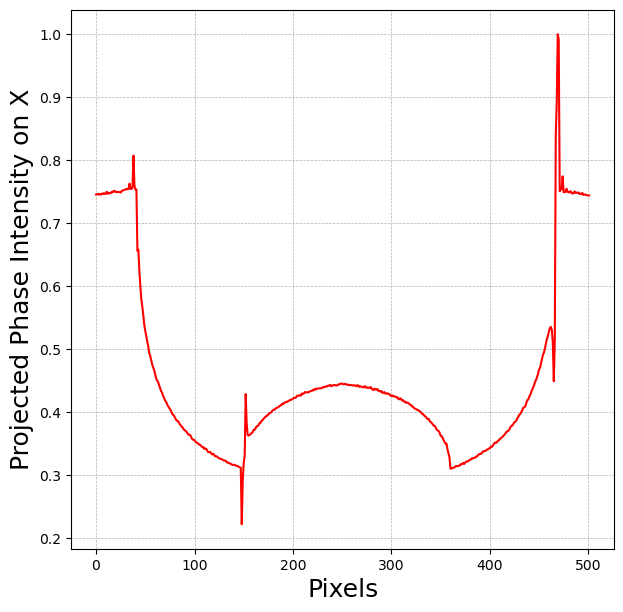

In [212]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(IC_Absor, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 18)
ax.set_ylabel("Projected Phase Intensity on X", fontsize = 18)
ax.grid(linestyle = '--', linewidth = 0.5)

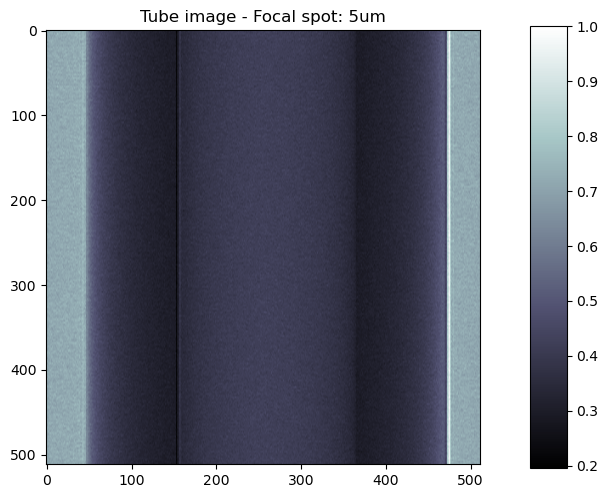

In [213]:
fig, ax = plt.subplots(figsize=(7, 7))
map_ = ax.imshow(Absor, cmap = "bone")
ax.set_title("{} image - Focal spot: {}".format(study, variation))
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)
#ax.plot(np.linspace(4, 508, 504), I_Absor*(500), '-', color="red")

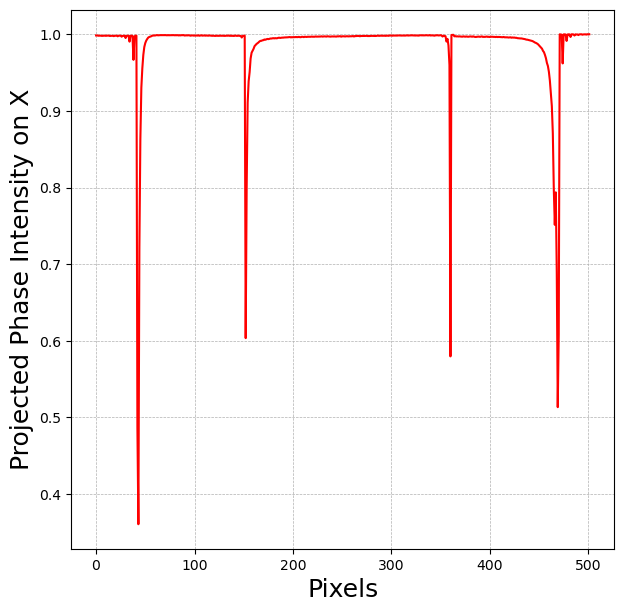

In [214]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(IC_Phase, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 18)
ax.set_ylabel("Projected Phase Intensity on X", fontsize = 18)
ax.grid(linestyle = '--', linewidth = 0.5)

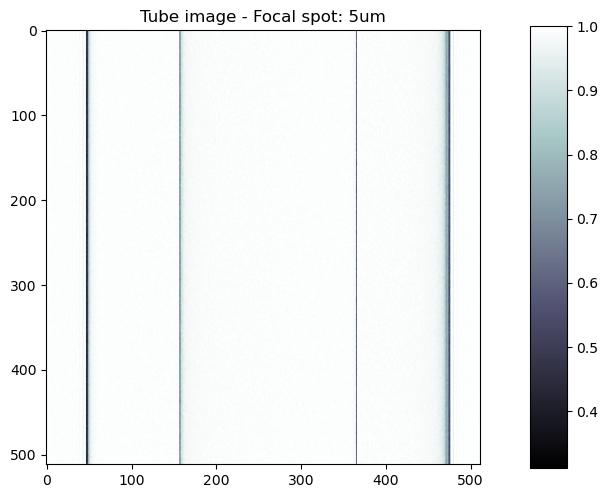

In [215]:
fig, ax = plt.subplots(figsize=(7, 7))
map_ = ax.imshow(Phase, cmap = "bone")
ax.set_title("{} image - Focal spot: {}".format(study, variation))
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)

## **Calculation of Signal-to-Noise and Contrast-to-Noise Ratios**

In [216]:
def SNR_and_CNR(mask, mask_back, image):
    try:
        if mask_back == None:
            mask_back = 1 - mask
    except:
        None
    
    ROI = mask*image
    ROI_Signal = ROI[mask == 1]
    BackG = mask_back*image
    BackG_Signal = BackG[mask_back == 1]

    Mean_ROI = np.mean(ROI_Signal)
    Std_ROI = np.std(ROI_Signal)

    Mean_BackG = np.mean(BackG_Signal)
    Std_BackG = np.std(BackG_Signal)

    
    SNR = Mean_ROI/Std_ROI
    CNR = np.abs(Mean_ROI - Mean_BackG)/Std_BackG
    return SNR, CNR

> # **Binary Mask of the Mammographic Phantom**

In [51]:
# Binary Mask of the Phantom:
scale = 2
delta = 0

# Image dimensions:
height, width = 256, 256

# Sphere centers:
center_x1, center_y1  = 79, 75 # Sphere 1
center_x2, center_y2 = 79, 182 # Sphere 2
center_x3, center_y3 = 185, 74 # Sphere 3
center_x4, center_y4 = 185, 181 # Sphere 4

# Radius:
radius1 = 12 + delta # Located at 0, 0
radius2 = 25 + delta # Located at 1, 0
radius3 = 48 + delta # Located at 0, 1
radius4 = 36 + delta # Located at 1, 1

# Coordinates set:
Y, X = np.ogrid[:height*scale, :width*scale]

# Bodies construction:
mask1 = ((X - center_x1*scale)**2 + (Y - center_y1*scale)**2) <= (radius1)**2
mask2 = ((X - center_x2*scale)**2 + (Y - center_y2*scale)**2) <= (radius2)**2
mask3 = ((X - center_x3*scale)**2 + (Y - center_y3*scale)**2) <= (radius3)**2
mask4 = ((X - center_x4*scale)**2 + (Y - center_y4*scale)**2) <= (radius4)**2

# Creating the masks:
mask1 = mask1.astype(np.uint8)
mask2 = mask2.astype(np.uint8)
mask3 = mask3.astype(np.uint8)
mask4 = mask4.astype(np.uint8)
mask = mask1 + mask2 + mask3 + mask4


> # **Binary Mask of the Tube:**

In [47]:
height, width = 512, 512
shape = (height, width)

# Crear una máscara vacía
mask_background = np.zeros(shape, dtype = bool)

mask_intermediate = np.zeros(shape, dtype = bool)

mask_inner = np.zeros(shape, dtype = bool)

background_xi, background_xf, background_yi, background_yf = 50, 472, 0, 512

intermediate1_xi, intermediate1_xf, intermediate1_yi, intermediate1_yf = 0, 50, 0, 512
intermediate2_xi, intermediate2_xf, intermediate2_yi, intermediate2_yf = 472, 512, 0, 512
intermediate3_xi, intermediate3_xf, intermediate3_yi, intermediate3_yf = 155, 360, 0, 512

inner_xi, inner_xf, inner_yi, inner_yf = 155, 360, 0, 512

mask_background[background_yi:background_yf, background_xi:background_xf] = True
mask_background = 1 - mask_background

mask_intermediate[intermediate1_yi:intermediate1_yf, intermediate1_xi:intermediate1_xf] = True
mask_intermediate[intermediate2_yi:intermediate2_yf, intermediate2_xi:intermediate2_xf] = True
mask_intermediate[intermediate2_yi:intermediate3_yf, intermediate3_xi:intermediate3_xf] = True
mask_intermediate = 1 - mask_intermediate

mask_inner[inner_yi:inner_yf, inner_xi:inner_xf] = True
mask_inner = 1 - mask_inner

mask = mask_inner

(-0.5, 511.5, 511.5, -0.5)

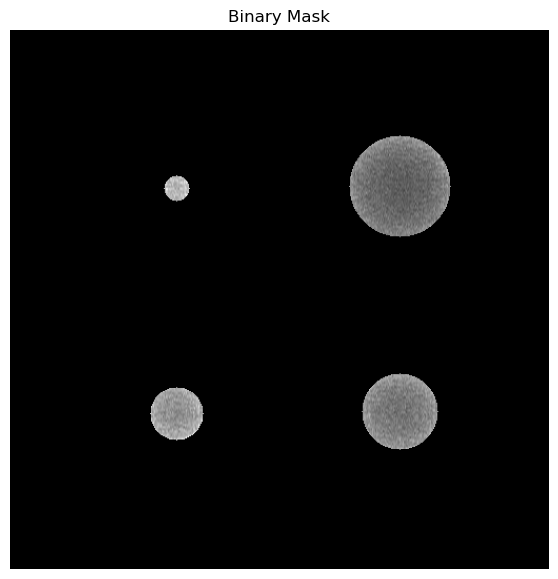

In [52]:
# Showing the ROI : Region of Interests
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mask*Absor, cmap='gray')
ax.set_title('Binary Mask')
ax.axis('off')

In [53]:
SNR_and_CNR(mask, None, Phase)

(40.485210885954, 0.10025342385766645)

In [54]:
mask_back = 1 - mask
SNR_and_CNR(mask3, mask_back, Phase)

(39.50959543522448, 0.1336724712563583)

In [55]:
Set_PM = ["10um", "50um", "100um", "150um", "200um"] # Phantom_Mat
Set_TA = ["10um", "50um", "100um", "150um", "200um"] # Tubes_All
Set = Set_TA # Chosen set

x_axis = []
for i in range(0, len(Set)):
    number = int(Set[i].replace("um", ""))
    x_axis.append(number)


SNR_absvalues = []
CNR_absvalues = []
a
SNR_phvalues = []
CNR_phvalues = []

for focal_spot in Set:
    images = LoadingImages(raw, directory, focal_spot, extension, pixel, n_dithstep, n_typeCOL, n_beamrun)
    images_maps = CreatingMaps(images)
    
    absortion = images_maps["Absortion Map:"][0]
    phase = images_maps["Phase Map:"][0]
    
    SNR_abs, CNR_abs = SNR_and_CNR(mask, None, absortion)
    SNR_ph, CNR_ph = SNR_and_CNR(mask, None, phase)
    
    SNR_absvalues.append(SNR_abs)
    CNR_absvalues.append(CNR_abs)

    SNR_phvalues.append(SNR_ph)
    CNR_phvalues.append(CNR_ph)

----- Set #1 is being analyzed ------
1. The dithering image raw_\Phantom_Mat\10um\1 has been succesfully ran with 2 beamruns.
----- Set #1 has been succesfully analyzed ------ 

----- Set #2 is being analyzed ------
1. The dithering image raw_\Phantom_Mat\10um\2 has been succesfully ran with 2 beamruns.
----- Set #2 has been succesfully analyzed ------ 

----- Set #3 is being analyzed ------
1. The dithering image raw_\Phantom_Mat\10um\3 has been succesfully ran with 2 beamruns.
----- Set #3 has been succesfully analyzed ------ 

----- Set #4 is being analyzed ------
1. The dithering image raw_\Phantom_Mat\10um\4 has been succesfully ran with 2 beamruns.
----- Set #4 has been succesfully analyzed ------ 

----- The Flat Field is being analyzed ------
1. The dithering image raw_\Phantom_Mat\10um\FF has been succesfully ran with 2 beamruns.
----- The Flat Field has been succesfully analyzed ------ 

The set of images was successfully normalized.
----- Set #1 is being analyzed ------
1. 

In [56]:
SNRm_abs, SNRb_abs = np.polyfit(x_axis, SNR_absvalues, 1)
CNRm_abs, CNRb_abs = np.polyfit(x_axis, CNR_absvalues, 1)

SNRm_ph, SNRb_ph = np.polyfit(x_axis, SNR_phvalues, 1)
CNRm_ph, CNRb_ph = np.polyfit(x_axis, CNR_phvalues, 1)

x_complete = np.linspace(x_axis[0], x_axis[-1], 100)
SNRy_abs = SNRm_abs*x_complete + SNRb_abs
CNRy_abs = CNRm_abs*x_complete + CNRb_abs

SNRy_ph = SNRm_ph*x_complete + SNRb_ph
CNRy_ph = CNRm_ph*x_complete + CNRb_ph

# Residues:

SNRabs_Residues = np.array([])
CNRabs_Residues = np.array([])
SNRph_Residues = np.array([])
CNRph_Residues = np.array([])

for i in range(0, len(x_axis)):
    SNRabs_residue = SNR_absvalues[i] - (SNRm_abs*x_axis[i] + SNRb_abs)
    CNRabs_residue = CNR_absvalues[i] - (CNRm_abs*x_axis[i] + CNRb_abs)

    SNRph_residue = SNR_phvalues[i] - (SNRm_ph*x_axis[i] + SNRb_ph)
    CNRph_residue = CNR_phvalues[i] - (CNRm_ph*x_axis[i] + CNRb_ph)

    SNRabs_Residues = np.append(SNRabs_Residues, SNRabs_residue)
    CNRabs_Residues = np.append(CNRabs_Residues, CNRabs_residue)

    SNRph_Residues = np.append(SNRph_Residues, SNRph_residue)
    CNRph_Residues = np.append(CNRph_Residues, CNRph_residue)

SNRabs_Residues = SNRabs_Residues/np.max(SNRabs_Residues)
CNRabs_Residues = CNRabs_Residues/np.max(CNRabs_Residues)

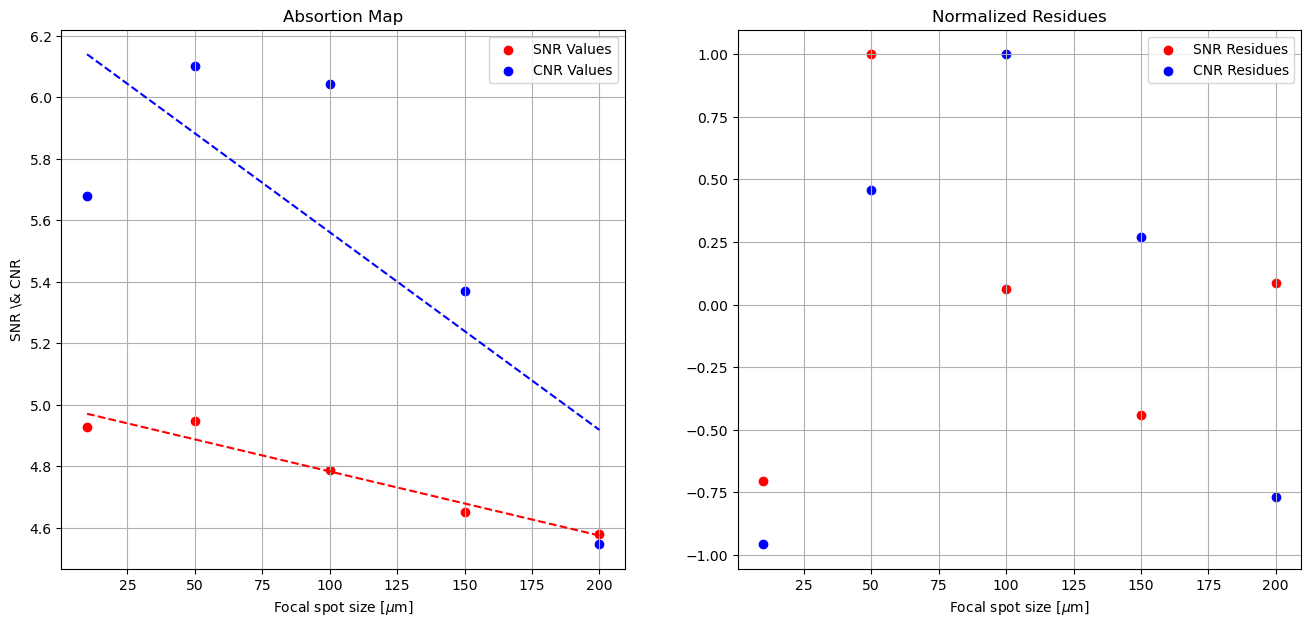

In [57]:
fig, ax = plt.subplots(ncols = 2, figsize=(16, 7))
ax[0].grid(True)
ax[1].grid(True)

ax[0].scatter(x_axis, SNR_absvalues, color = "red", label = "SNR Values")
ax[0].plot(x_complete, SNRy_abs, color = "red", linestyle = "--")

ax[0].scatter(x_axis, CNR_absvalues, color = "blue", label = "CNR Values")
ax[0].plot(x_complete, CNRy_abs, color = "blue", linestyle = "--")

ax[1].scatter(x_axis, SNRabs_Residues, color = "red", label = "SNR Residues")
ax[1].scatter(x_axis, CNRabs_Residues, color = "blue", label = "CNR Residues")

ax[0].set_xlabel(r"Focal spot size [$\mu$m]")
ax[0].set_ylabel(r"SNR \& CNR")
ax[0].set_title(r"Absortion Map")

ax[1].set_xlabel(r"Focal spot size [$\mu$m]")
ax[1].set_title(r"Normalized Residues")
ax[0].legend()
ax[1].legend()

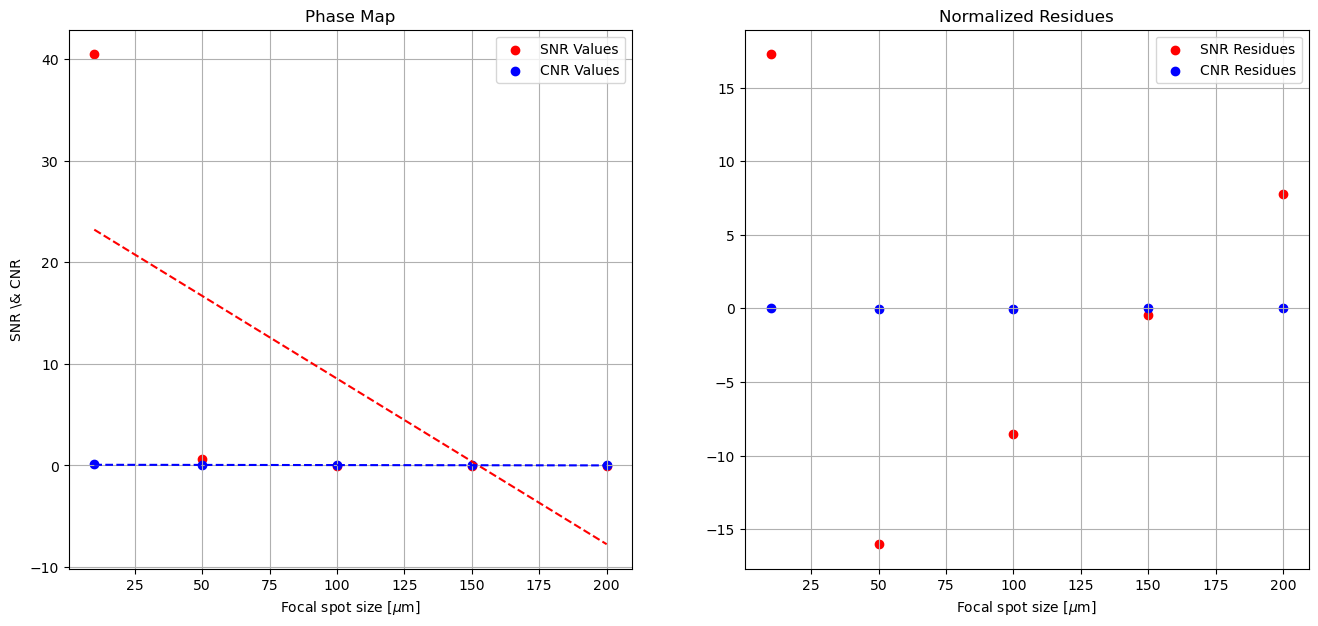

In [58]:
fig, ax = plt.subplots(ncols = 2, figsize=(16, 7))
ax[0].grid(True)
ax[1].grid(True)

ax[0].scatter(x_axis, SNR_phvalues, color = "red", label = "SNR Values")
ax[0].plot(x_complete, SNRy_ph, color = "red", linestyle = "--")

ax[0].scatter(x_axis, CNR_phvalues, color = "blue", label = "CNR Values")
ax[0].plot(x_complete, CNRy_ph, color = "blue", linestyle = "--")

ax[1].scatter(x_axis, SNRph_Residues, color = "red", label = "SNR Residues")
ax[1].scatter(x_axis, CNRph_Residues, color = "blue", label = "CNR Residues")

ax[0].set_xlabel(r"Focal spot size [$\mu$m]")
ax[0].set_ylabel(r"SNR \& CNR")
ax[0].set_title(r"Phase Map")

ax[1].set_xlabel(r"Focal spot size [$\mu$m]")
ax[1].set_title(r"Normalized Residues")
ax[0].legend()
ax[1].legend()